# Optimal thermal control with linprog

Linprog used as a baseline performance, for comparison with other approximate optimal control methods in [thermal_manage.ipynb](thermal_manage.ipynb).

Pierre Haessig, May 2016

In [1]:
from __future__ import unicode_literals, print_function, division

In [2]:
import numpy as np
import cvxpy as cx
cx.__version__

'0.4.2'

notice: the cvxpy API may change in the forthcoming 1.0 version (cf. [issue #199](https://github.com/cvxgrp/cvxpy/issues/199))

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sylvainchatel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
mpl.style.use(['seaborn-deep', 'seaborn-whitegrid', 'seaborn-notebook'])
mpl.rcParams['figure.figsize'] = [8, 3.5]  # thin plots for time series

## Problem definition

Load problem data. choice of units: hours, kW, Celsius degrees.

In [5]:
from therm_data import dt, C, R, P_max

In [6]:
print('Timestep dt: {} h'.format(dt))
print('Capacity C: {} kWh/K'.format(C))
print('Resistance R: {} °C/kW'.format(R))
print('P_max: {} kWh'.format(P_max))

Timestep dt: 0.1 h
Capacity C: 1 kWh/K
Resistance R: 20 °C/kW
P_max: 3 kWh


In [7]:
N_sim = int(24/dt)

dynamics in discrete time (backward Euler), with timestep $\Delta_t$ :

$$T^+ = T + \frac{\Delta_t}{C} ( P - \frac{T-T_{out}}{R} ) $$

In [8]:
from therm_data import T0, T_out, occupancy, T_abs, T_pres

In [9]:
t = np.arange(N_sim)*dt
occ = occupancy(t)
T_min = np.zeros(N_sim) + T_abs # °C
T_min[occ] = T_pres

## LP problem

with hard temperature constraint $T ≥ T_{min}$

Optimization variables:

In [10]:
P = cx.Variable(N_sim)
T = cx.Variable(N_sim)

Objective: minimize total consumption

In [11]:
objective = cx.Minimize(cx.sum_entries(P))
objective

Minimize(Expression(AFFINE, UNKNOWN, (1, 1)))

Build the constraints

In [12]:
# Heating limits:
c_Pmin = P >= 0
c_Pmax = P <= P_max
constraints = [c_Pmin, c_Pmax]

# min Temperature set point
c_Tmin = T >= T_min
constraints += [c_Tmin]

# Temp dynamics
deltaT = dt/C*(P[:-1] - (T[:-1]-T_out)/R)
c_dyn = T[1:] == T[:-1] + deltaT
constraints += [c_dyn]

# Initial temperature
c_T0 = T[0] == T0
constraints += [c_T0]


print('Constraints:')
for c in constraints:
    print(c.OP_NAME, end='')
    print(' ' +  repr(c.args[0]))
    print('   ' +  repr(c.args[1]))
    print()

Constraints:
<= Constant(CONSTANT, ZERO, (1, 1))
   Variable(240, 1)

<= Variable(240, 1)
   Constant(CONSTANT, POSITIVE, (1, 1))

<= Constant(CONSTANT, POSITIVE, (240, 1))
   Variable(240, 1)

== Expression(AFFINE, UNKNOWN, (239, 1))
   Expression(AFFINE, UNKNOWN, (239, 1))

== Expression(AFFINE, UNKNOWN, (1, 1))
   Constant(CONSTANT, POSITIVE, (1, 1))



Solve the Linear Program:

In [13]:
prob = cx.Problem(objective, constraints)
result = prob.solve()

print('energy consum: {:.6f} kW avg'.format(result/N_sim))

energy consum: 0.939061 kW avg


In [14]:
def plot_traj(t, T, T_out, T_min, P):
    'plot of a simulation (temperature and heating)'
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,4))
    
    ax1.plot(t, T)
    ax1.plot(t, T_min)

    ax2.plot(t, P, 'r')

    ax1.set(
        ylabel='Temp (°C)',
        ylim=(T_abs-0.5, T_pres+0.5)
    )
    ax2.set(
        xlabel='t (h)',
        ylabel='P (kW)',
        ylim=(P_max*-.05, P_max*1.05)
    )
    fig.tight_layout()
    
    return fig, (ax1, ax2)

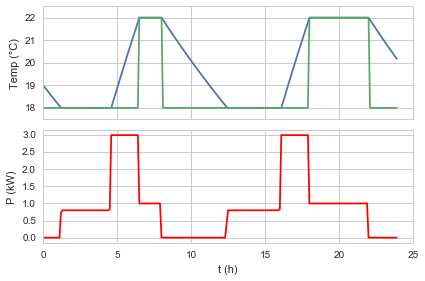

In [15]:
plot_traj(t, T.value, T_out, T_min, P.value);

Save result (and convert 2D column matrices into 1D arrays)

In [16]:
np.savez('thermal_lp_sol.npz',
         T = np.array(T.value)[:, 0], 
         P = np.array(P.value)[:, 0],
         T_out = T_out,
         T_min = T_min
        )

### A look at dual variables (shadow price of constraints)

In [17]:
c_T0.dual_value/N_sim

0.039038112220211335

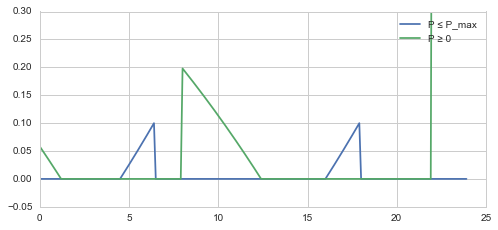

In [18]:
plt.plot(t, c_Pmax.dual_value, label='P ≤ P_max')
plt.plot(t, c_Pmin.dual_value, label='P ≥ 0')
plt.legend()
plt.ylim(-0.05, 0.3);

Observations:

* the $P≥0$ constraint is active in cool down phases. → the optimizer would like to extract power (using a reversible heater if it existed)
* the $P≤P_{max}$ constraint is active in the preheating phases. → the optimized would like more power to reduce the duration of preheating (which wastes some energy to the outside).

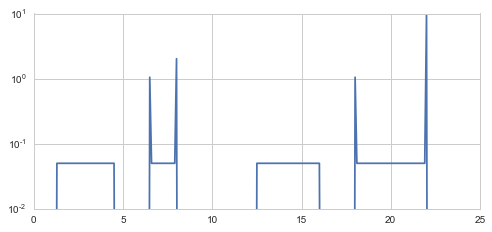

In [19]:
plt.semilogy(t, c_Tmin.dual_value)
#plt.plot(t, c_Tmin.dual_value)
plt.ylim(ymin = 1e-2);

Observations for $T≥ T_{min}$ constraint:

* a low constant cost whenever it must be hold continuously
* a high transient cost for edges of high $T_{min}$ values (when occupartion starts and when occupation stops).

This implies that reducing occupancy periods is the best way to save energy!

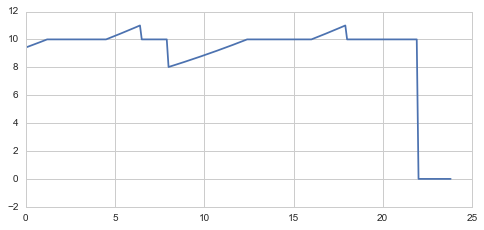

In [20]:
plt.plot(t[:-1], c_dyn.dual_value);

Observations: 

* the dynamics has always a positive price (with some minor variations),
* except near the end of time, when temperature is in free decay.

Explanation attempt:

* the constant positive price shows that the system would appreciate a free constant temperature increase term in the dynamics! ($T^+ = T + ... + \Delta T_0$)
* the variations corresponds to the $P_{min}$ and $P_{max}$ constraints, scaled by $\Delta_t$ (cf. dynamical equation)

## Relaxation of the min temperature constraint

The min temperature constraint
$$T ≥ T_{min} $$

is replaced by

$$ T ≥ T_{min} - T_{diff}$$
where slack variable $T_{diff} ≥0$ is heavily penalized

In [21]:
P_rlx = cx.Variable(N_sim)
T_rlx = cx.Variable(N_sim)
# new slack variable:
T_diff = cx.Variable(N_sim)

In [22]:
comfort_weight=10

objective_rlx = cx.Minimize(cx.sum_entries(P_rlx) +\
                        comfort_weight*cx.sum_entries(T_diff))
objective_rlx

Minimize(Expression(AFFINE, UNKNOWN, (1, 1)))

Build the constraints

In [23]:
# Heating limits:
constraints_rlx  = [P_rlx >= 0, P_rlx <= P_max]
# min Temperature set point, RELAXED
constraints_rlx  += [T_rlx >= T_min - T_diff]
constraints_rlx  += [T_diff >= 0]
# Temp dynamics
deltaT = dt/C*(P_rlx[:-1] - (T_rlx[:-1]-T_out)/R)
constraints_rlx  += [T_rlx[1:] == T_rlx[:-1] + deltaT]
# T0
constraints_rlx  += [T_rlx[0] == T0]

print('Constraints:')
for c in constraints_rlx :
    print(c.OP_NAME, end='')
    print(' ' +  repr(c.args[0]))
    print('   ' +  repr(c.args[1]))
    print()

Constraints:
<= Constant(CONSTANT, ZERO, (1, 1))
   Variable(240, 1)

<= Variable(240, 1)
   Constant(CONSTANT, POSITIVE, (1, 1))

<= Expression(AFFINE, UNKNOWN, (240, 1))
   Variable(240, 1)

<= Constant(CONSTANT, ZERO, (1, 1))
   Variable(240, 1)

== Expression(AFFINE, UNKNOWN, (239, 1))
   Expression(AFFINE, UNKNOWN, (239, 1))

== Expression(AFFINE, UNKNOWN, (1, 1))
   Constant(CONSTANT, POSITIVE, (1, 1))



Solve the Linear Program:

In [24]:
prob_rlx  = cx.Problem(objective_rlx , constraints_rlx )
result_rlx  = prob_rlx .solve()
result_rlx

225.37462333657487

In [25]:
ccom = T_diff.value.mean()*comfort_weight
cener = P_rlx.value.mean()
print('energy consum: {:.3f} kW avg'.format(cener))
print('comfort violation penal: {:.3f} (with confort weight {} kW/°)'.format(
        ccom, comfort_weight))
print('LP avg cost: {:.6f}'.format(result_rlx /N_sim))

energy consum: 0.936 kW avg
comfort violation penal: 0.003 (with confort weight 10 kW/°)
LP avg cost: 0.939061


Difference in the result:

In [26]:
result_rlx - result

-3.6903600175719475e-09

In [27]:
print('max T_min violation: {:.4f} °C'.format(T_diff.value.max()))

max T_min violation: 0.0631 °C


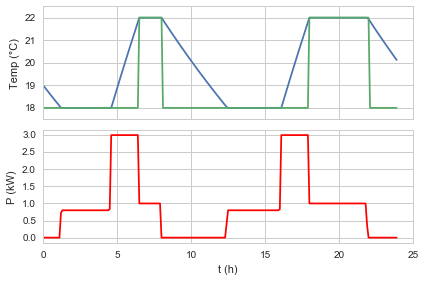

In [28]:
plot_traj(t, T_rlx.value, T_out, T_min, P_rlx.value);

### Zoom at the difference

In [29]:
t_zoom = (21.5, 22.5) # h

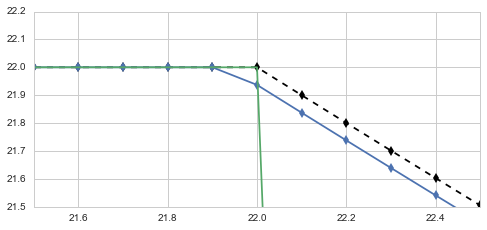

In [30]:
plt.plot(t, T.value, 'kd--')
plt.plot(t, T_rlx.value, 'd-')
plt.plot(t, T_min)
plt.xlim(*t_zoom)
plt.ylim(T_pres-0.5, T_pres+0.2);

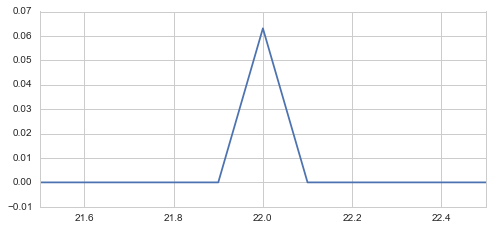

In [31]:
plt.plot(t, T_diff.value)
plt.xlim(*t_zoom);

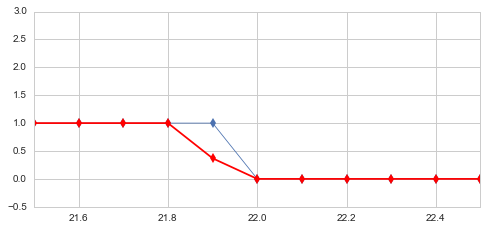

In [32]:
plt.plot(t, P.value, 'd-', lw=0.8);
plt.plot(t, P_rlx.value, 'rd-')
plt.xlim(*t_zoom);

Observation:

with `comfort_weight = 10`, there is a small trade off of energy against comfort near the end of the problem (-0.063 °C loss at 21.9 h). Energy consumption is slighlty reduced, but total LP cost is the same however (at least 4 digits)

with `comfort_weight = 100`, it becomes negligible